In [1]:
import pandas as pd
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils.validation import check_is_fitted
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from skimpy import clean_columns

import os
from configparser import ConfigParser
import numerapi

/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
config = ConfigParser()
config.read('/home/melgazar9/scripts/github/trading/numerai_project/numerai_keys.ini')
napi = numerapi.NumerAPI(config['KEYS']['NUMERAI_PUBLIC_KEY'], config['KEYS']['NUMERAI_SECRET_KEY'])

In [3]:
napi.list_datasets()

['example_predictions.csv',
 'example_predictions.parquet',
 'example_validation_predictions.csv',
 'example_validation_predictions.parquet',
 'features.json',
 'numerai_datasets.zip',
 'numerai_live_data.csv',
 'numerai_live_data.parquet',
 'numerai_live_data_int8.csv',
 'numerai_live_data_int8.parquet',
 'numerai_tournament_data.csv',
 'numerai_tournament_data.parquet',
 'numerai_tournament_data_int8.csv',
 'numerai_tournament_data_int8.parquet',
 'numerai_training_data.csv',
 'numerai_training_data.parquet',
 'numerai_training_data_int8.csv',
 'numerai_training_data_int8.parquet',
 'numerai_validation_data.csv',
 'numerai_validation_data.parquet',
 'numerai_validation_data_int8.csv',
 'numerai_validation_data_int8.parquet']

In [11]:
df_train = pd.read_csv(napi.get_latest_data_url(data_type='training'))
df_train.head(2)

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.0,0.5,0.25,0.00,0.5,0.25,0.25,...,1.0,1.0,0.75,0.5,0.75,0.50,1.0,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.0,0.0,0.00,0.25,0.5,0.00,0.00,...,1.0,1.0,0.00,0.0,0.75,0.25,0.0,0.25,1.00,0.25


In [5]:
df_val_test_live = pd.read_csv(napi.get_latest_data_url(data_type='tournament'))
df_val_test_live.head(2)

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.5,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.0,0.0,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.0,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.5,0.5,0.50


In [9]:
df_val_test_live['data_type'].value_counts()

test          1812999
validation     137779
live             5331
Name: data_type, dtype: int64

In [16]:
input_features = df_train.filter(like='feature_').columns

### create train-test-split sets

In [19]:
X_train, y_train = df_train[input_features], df_train['target']
X_val, y_val = df_val_test_live[df_val_test_live['data_type']=='validation'][input_features], df_val_test_live[df_val_test_live['data_type']=='validation']['target']
X_test, y_test = df_val_test_live[df_val_test_live['data_type'].isin(['test', 'live'])][input_features], df_val_test_live[df_val_test_live['data_type'].isin(['test', 'live'])]['target']

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((501808, 310),
 (501808,),
 (137779, 310),
 (137779,),
 (1818330, 310),
 (1818330,))

### preprocessing

In [20]:
def ds_print(*args, verbose=True):
    if verbose: print(*args)
def ds_print(*args, verbose=True):
    if verbose: print(*args)

class PreprocessFeatures(TransformerMixin):
    """
        Parameters
        ----------
        preserve_vars : A list of variables that won't be fitted or transformed by any sort of feature engineering
        target : A string - the name of the target variable.
        remainder : A string that gets passed to the column transformer whether to
                    drop preserve_vars or keep them in the final dataset
                    options are 'drop' or 'passthrough'
        max_oh_cardinality : A natural number - one-hot encode all features with unique categories <= to this value
        FE_pipeline_dict : Set to None to use "standard" feature engineering pipeline. Otherwise, supply a dictionary of pipelines to hc_pipe, oh_pipe, numeric_pipe, and custom_pipe
        n_jobs : An int - the number of threads to use
        copy : boolean to copy X_train and X_test while preprocessing
        -------
        Attributes
        detect_feature_types attributes are dictionary attributes
        fit attributes are sklearn ColumnTransformer attributes
        -------
        Returns
        detect features returns a dictionary
        fit returns a ColumnTransformer object
        We can call fit_transform because we inherited the sklearn base TransformerMixin class
        -------
    """

    def __init__(self,
                 target=None,
                 preserve_vars=None,
                 FE_pipeline_dict=None,
                 remainder='drop',
                 max_oh_cardinality=11,
                 detect_dtypes=True,
                 numeric_features=None,
                 oh_features=None,
                 hc_features=None,
                 overwrite_detection=True,
                 n_jobs=-1,
                 copy=True,
                 verbose=True):

        self.preserve_vars = preserve_vars
        self.target = target
        self.FE_pipeline_dict = FE_pipeline_dict
        self.remainder = remainder
        self.max_oh_cardinality = max_oh_cardinality
        self.detect_dtypes = detect_dtypes
        self.numeric_features = [] if numeric_features is None else numeric_features
        self.oh_features = [] if oh_features is None else oh_features
        self.hc_features = [] if hc_features is None else hc_features
        self.overwrite_detection = overwrite_detection
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.copy = copy

        self.preserve_vars = [] if self.preserve_vars is None else self.preserve_vars
        self.target = '' if self.target is None else self.target

    def detect_feature_types(self, X):

        if self.copy: X = X.copy()

        if not self.detect_dtypes:
            ds_print('Not detecting dtypes.', verbose=self.verbose)
            feature_dict = {'numeric_features': self.numeric_features,
                            'oh_features': self.oh_features,
                            'hc_features': self.hc_features,
                            'custom_features': self.FE_pipeline_dict['custom_pipeline'].values()}
            return feature_dict

        if self.FE_pipeline_dict is not None and 'custom_pipeline' in self.FE_pipeline_dict.keys():
                custom_features = list(itertools.chain(*self.FE_pipeline_dict['custom_pipeline'].values()))
        else:
            custom_features = []

        assert len(
            np.intersect1d(list(set(self.numeric_features + self.oh_features + self.hc_features + custom_features)),
                           self.preserve_vars)) == 0, \
            'There are duplicate features in preserve_vars either the input numeric_features, oh_features, or hc_features'

        detected_numeric_vars = make_column_selector(dtype_include=np.number)(
            X[[i for i in X.columns if i not in self.preserve_vars + [self.target] + custom_features]])
        detected_oh_vars = [i for i in X.loc[:, (X.nunique() < self.max_oh_cardinality) & (X.nunique() > 1)].columns if
                            i not in self.preserve_vars + [self.target] + custom_features]
        detected_hc_vars = X[[i for i in X.columns if i not in self.preserve_vars + custom_features]] \
            .select_dtypes(['object', 'category']) \
            .apply(lambda col: col.nunique()) \
            .loc[lambda x: x > self.max_oh_cardinality] \
            .index.tolist()

        discarded_features = [i for i in X.isnull().sum()[X.isnull().sum() == X.shape[0]].index if i not in self.preserve_vars]

        numeric_features = list(set([i for i in self.numeric_features + [i for i in detected_numeric_vars if
                                                                         i not in list(self.oh_features) + list(
                                                                             self.hc_features) + list(
                                                                             discarded_features) + custom_features]]))

        oh_features = list(set([i for i in self.oh_features + [i for i in detected_oh_vars if
                                                               i not in list(self.numeric_features) + list(
                                                                   self.hc_features) + list(
                                                                   discarded_features) + custom_features]]))

        hc_features = list(set([i for i in self.hc_features + [i for i in detected_hc_vars if
                                                               i not in list(self.numeric_features) + list(
                                                                   self.oh_features) + list(
                                                                   discarded_features) + custom_features]]))

        ds_print('Overlap between numeric and oh_features: ' + str(list(set(np.intersect1d(numeric_features, oh_features)))), verbose=self.verbose)
        ds_print('Overlap between numeric and hc_features: ' + str(list(set(np.intersect1d(numeric_features, hc_features)))), verbose=self.verbose)
        ds_print('Overlap between numeric oh_features and hc_features: ' + str(list(set(np.intersect1d(oh_features, hc_features)))), verbose=self.verbose)
        ds_print('Overlap between oh_features and hc_features will be moved to oh_features', verbose=self.verbose)

        if self.overwrite_detection:
            numeric_features = [i for i in numeric_features if
                                i not in oh_features + hc_features + discarded_features + custom_features]
            oh_features = [i for i in oh_features if
                           i not in hc_features + numeric_features + discarded_features + custom_features]
            hc_features = [i for i in hc_features if
                           i not in oh_features + numeric_features + discarded_features + custom_features]
        else:
            numeric_overlap = [i for i in numeric_features if
                               i in oh_features or i in hc_features and i not in discarded_features + custom_features]
            oh_overlap = [i for i in oh_features if
                          i in hc_features or i in numeric_features and i not in discarded_features + custom_features]
            hc_overlap = [i for i in hc_features if
                          i in oh_features or i in numeric_features and i not in discarded_features + custom_features]

            if numeric_overlap or oh_overlap or hc_overlap:
                raise('Error - There is an overlap between numeric, oh, and hc features! To ignore this set overwrite_detection to True.')

        all_features = list(set(numeric_features + oh_features + hc_features + discarded_features + custom_features))
        all_features_debug = set(all_features) - set([i for i in X.columns if i not in self.preserve_vars + [self.target]])

        if len(all_features_debug) > 0:
            print('\n{}\n'.format(all_features_debug))
            raise('There was a problem detecting all features!! Check if there is an overlap between preserve_vars and other custom input features')

        ds_print('\nnumeric_features:' + str(numeric_features), verbose=self.verbose)
        ds_print('\noh_features:' + str(oh_features), verbose=self.verbose)
        ds_print('\nhc_features:' + str(hc_features), verbose=self.verbose)
        ds_print('\ndiscarded_features:' + str(discarded_features), verbose=self.verbose)
        ds_print('\ncustom_pipeline:' + str(custom_features), verbose=self.verbose)

        feature_dict = {'numeric_features': numeric_features,
                        'oh_features': oh_features,
                        'hc_features': hc_features,
                        'custom_features': custom_features,
                        'discarded_features': discarded_features}

        return feature_dict

    def fit(self, X, y=None, remainder='drop'):

        """ This breaks the sklearn standard of returning self, but I don't currently know a better way to do this """

        if self.target is None and y is not None:
            self.target = y.name

        assert y is not None and self.target is not None, '\n Both self.target and y cannot be None!'

        if self.copy:
            X = X.copy()
            if y is not None:
                y = y.copy()

        feature_types = self.detect_feature_types(X)

        if self.FE_pipeline_dict is None:

            # Default below
            numeric_pipe = make_pipeline(
                FunctionTransformer(lambda x: x.replace([np.inf, -np.inf], np.nan)),
                # Winsorizer(distribution='gaussian', tail='both', fold=3, missing_values = 'ignore'),
                MinMaxScaler(feature_range=(0, 1)),
                SimpleImputer(strategy='median', add_indicator=True)
            )

            hc_pipe = make_pipeline(
                FunctionTransformer(lambda x: x.replace([np.inf, -np.inf], np.nan).astype(str)),
                TargetEncoder(return_df=True,
                              handle_missing='value',
                              handle_unknown='value',
                              min_samples_leaf=10)
            )

            oh_pipe = make_pipeline(
                FunctionTransformer(lambda x: x.replace([np.inf, -np.inf], np.nan).astype(str)),
                OneHotEncoder(handle_unknown='ignore', sparse=False)
            )

            custom_pipe = None

        else:
            hc_pipe = self.FE_pipeline_dict['hc_pipe']
            numeric_pipe = self.FE_pipeline_dict['numeric_pipe']
            oh_pipe = self.FE_pipeline_dict['oh_pipe']
            custom_pipe = self.FE_pipeline_dict['custom_pipeline'] if 'custom_pipeline' in self.FE_pipeline_dict.keys() else {}

        transformers = [
            ('hc_pipeline', hc_pipe, feature_types['hc_features']),
            ('numeric_pipeline', numeric_pipe, feature_types['numeric_features']),
            ('oh_encoder', oh_pipe, feature_types['oh_features'])
        ]

        if custom_pipe:
            i = 0
            for cp in custom_pipe.keys():
                transformers.append(('custom_pipe{}'.format(str(i)), cp, custom_pipe[cp]))
                i += 1

        if y is None:
            feature_transformer = ColumnTransformer(
                transformers=transformers,
                remainder=remainder,
                n_jobs=self.n_jobs).fit(X)
        else:
            feature_transformer = ColumnTransformer(
                transformers=transformers,
                remainder=remainder,
                n_jobs=self.n_jobs).fit(X, y)

        setattr(feature_transformer, 'feature_types', feature_types)

        return feature_transformer


def get_column_names_from_ColumnTransformer(column_transformer, clean_column_names=True, verbose=True):

    """
    Reference: Kyle Gilde: https://github.com/kylegilde/Kaggle-Notebooks/blob/master/Extracting-and-Plotting-Scikit-Feature-Names-and-Importances/feature_importance.py
    Description: Get the column names from the a ColumnTransformer containing transformers & pipelines
    Parameters
    ----------
    verbose: Bool indicating whether to print summaries. Default set to True.
    Returns
    -------
    a list of the correct feature names
    Note:
    If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns,
    it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns
    to the dataset that didn't exist before, so there should come last in the Pipeline.
    Inspiration: https://github.com/scikit-learn/scikit-learn/issues/12525
    """

    assert isinstance(column_transformer, ColumnTransformer), "Input isn't a ColumnTransformer"

    check_is_fitted(column_transformer)

    new_feature_names, transformer_list = [], []

    for i, transformer_item in enumerate(column_transformer.transformers_):
        transformer_name, transformer, orig_feature_names = transformer_item
        orig_feature_names = list(orig_feature_names)

        if len(orig_feature_names) == 0:
            continue

        if verbose:
            print(f"\n\n{i}.Transformer/Pipeline: {transformer_name} {transformer.__class__.__name__}\n")
            print(f"\tn_orig_feature_names:{len(orig_feature_names)}")

        if transformer == 'drop':
            continue

        if isinstance(transformer, Pipeline):
            # if pipeline, get the last transformer in the Pipeline
            transformer = transformer.steps[-1][1]

        if hasattr(transformer, 'get_feature_names_out'):
            if 'input_features' in transformer.get_feature_names_out.__code__.co_varnames:
                names = list(transformer.get_feature_names_out(orig_feature_names))
            else:
                names = list(transformer.get_feature_names_out())
        elif hasattr(transformer, 'get_feature_names'):
            if 'input_features' in transformer.get_feature_names.__code__.co_varnames:
                names = list(transformer.get_feature_names(orig_feature_names))
            else:
                names = list(transformer.get_feature_names())

        elif hasattr(transformer, 'indicator_') and transformer.add_indicator:
            # is this transformer one of the imputers & did it call the MissingIndicator?

            missing_indicator_indices = transformer.indicator_.features_
            missing_indicators = [orig_feature_names[idx] + '_missing_flag' \
                                  for idx in missing_indicator_indices]
            names = orig_feature_names + missing_indicators

        elif hasattr(transformer, 'features_'):
            # is this a MissingIndicator class?
            missing_indicator_indices = transformer.features_
            missing_indicators = [orig_feature_names[idx] + '_missing_flag' \
                                  for idx in missing_indicator_indices]

        else:

            names = orig_feature_names

        if verbose:
            print(f"\tn_new_features:{len(names)}")
            print(f"\tnew_features: {names}\n")

        new_feature_names.extend(names)
        transformer_list.extend([transformer_name] * len(names))

    transformer_list, column_transformer_features = transformer_list, new_feature_names

    if clean_column_names:
        new_feature_names = list(clean_columns(pd.DataFrame(columns=new_feature_names)).columns)
    return new_feature_names

In [21]:
feature_transformer = PreprocessFeatures().fit(X_train, y_train)

Overlap between numeric and oh_features: ['feature_constitution92', 'feature_strength36', 'feature_charisma55', 'feature_wisdom40', 'feature_constitution22', 'feature_strength18', 'feature_constitution108', 'feature_wisdom26', 'feature_charisma31', 'feature_constitution57', 'feature_constitution16', 'feature_dexterity8', 'feature_wisdom11', 'feature_charisma10', 'feature_charisma14', 'feature_dexterity3', 'feature_constitution89', 'feature_strength9', 'feature_wisdom24', 'feature_charisma12', 'feature_constitution42', 'feature_strength27', 'feature_constitution37', 'feature_strength29', 'feature_charisma60', 'feature_charisma41', 'feature_strength2', 'feature_charisma86', 'feature_strength17', 'feature_charisma2', 'feature_charisma30', 'feature_charisma54', 'feature_charisma4', 'feature_constitution85', 'feature_strength30', 'feature_constitution73', 'feature_wisdom46', 'feature_wisdom29', 'feature_charisma78', 'feature_constitution36', 'feature_strength23', 'feature_charisma64', 'feat

In [22]:
output_features = get_column_names_from_ColumnTransformer(feature_transformer)



2.Transformer/Pipeline: oh_encoder Pipeline

	n_orig_feature_names:310
	n_new_features:1550
	new_features: ['feature_constitution92_0.0', 'feature_constitution92_0.25', 'feature_constitution92_0.5', 'feature_constitution92_0.75', 'feature_constitution92_1.0', 'feature_strength36_0.0', 'feature_strength36_0.25', 'feature_strength36_0.5', 'feature_strength36_0.75', 'feature_strength36_1.0', 'feature_charisma55_0.0', 'feature_charisma55_0.25', 'feature_charisma55_0.5', 'feature_charisma55_0.75', 'feature_charisma55_1.0', 'feature_wisdom40_0.0', 'feature_wisdom40_0.25', 'feature_wisdom40_0.5', 'feature_wisdom40_0.75', 'feature_wisdom40_1.0', 'feature_constitution22_0.0', 'feature_constitution22_0.25', 'feature_constitution22_0.5', 'feature_constitution22_0.75', 'feature_constitution22_1.0', 'feature_strength18_0.0', 'feature_strength18_0.25', 'feature_strength18_0.5', 'feature_strength18_0.75', 'feature_strength18_1.0', 'feature_constitution108_0.0', 'feature_constitution108_0.25', 'feat

In [23]:
X_train_transformed = pd.DataFrame(feature_transformer.transform(X_train), columns=output_features, index=y_train.index)
X_val_transformed = pd.DataFrame(feature_transformer.transform(X_val), columns=output_features, index=y_val.index)
X_test_transformed = pd.DataFrame(feature_transformer.transform(X_test), columns=output_features, index=y_test.index)

In [56]:
from tpot import TPOTRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [63]:
tmp = LGBMRegressor(n_estimators=250, num_leaves=9,
                  max_depth=9, learning_rate=0.01,
                  class_weight={0: 0.3,
                                0.25: 0.17,
                                0.5: 0.05,
                                0.75: 0.18,
                                1: 0.3}).fit(X_train_transformed, y_train)

<AxesSubplot:ylabel='Frequency'>

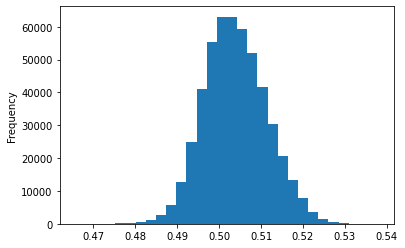

In [64]:
pd.Series(tmp.predict(X_train_transformed)).plot(kind='hist', bins=30)

In [67]:
tmp = LGBMRegressor(n_estimators=250, num_leaves=9,
                  max_depth=9, learning_rate=0.01, class_weight='balanced').fit(X_train_transformed, y_train)

<AxesSubplot:ylabel='Frequency'>

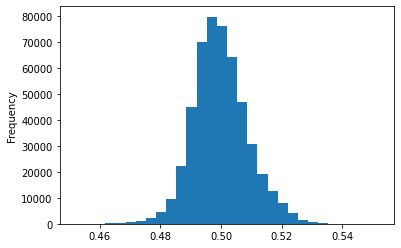

In [68]:
pd.Series(tmp.predict(X_train_transformed)).plot(kind='hist', bins=30)

In [74]:
%%time
model_pipe = make_pipeline(
    #PCA(n_components=100),
    StackingRegressor(estimators=[
        ('linear_model', LinearRegression()),
        ('elastic_net', ElasticNet(random_state=0)),
        ('lgbm', LGBMRegressor(n_estimators=250, num_leaves=9,
                               max_depth=9, learning_rate=0.01,
                               class_weight={0: 0.3,
                                             0.25: 0.17,
                                             0.5: 0.05,
                                             0.75: 0.18,
                                             1: 0.3})),
        ('catboost', CatBoostRegressor(random_state=0, iterations=1000,
                                       learning_rate=.1, max_depth=12,
                                       loss_function='RMSE', thread_count=-1)),
        ('xgb', XGBRegressor(n_estimators=250, max_depth=12, learning_rate=0.01, subsample=0.8, n_jobs=-1))
        ])
    ).fit(X_train_transformed, y_train)

0:	learn: 0.2231321	total: 325ms	remaining: 5m 24s
1:	learn: 0.2229610	total: 599ms	remaining: 4m 58s
2:	learn: 0.2227874	total: 877ms	remaining: 4m 51s
3:	learn: 0.2226330	total: 1.16s	remaining: 4m 47s
4:	learn: 0.2224795	total: 1.44s	remaining: 4m 45s
5:	learn: 0.2223109	total: 1.72s	remaining: 4m 44s
6:	learn: 0.2221363	total: 2s	remaining: 4m 43s
7:	learn: 0.2220094	total: 2.27s	remaining: 4m 42s
8:	learn: 0.2218457	total: 2.55s	remaining: 4m 41s
9:	learn: 0.2217048	total: 2.84s	remaining: 4m 41s
10:	learn: 0.2215277	total: 3.13s	remaining: 4m 41s
11:	learn: 0.2213695	total: 3.41s	remaining: 4m 40s
12:	learn: 0.2212108	total: 3.69s	remaining: 4m 39s
13:	learn: 0.2210656	total: 3.98s	remaining: 4m 40s
14:	learn: 0.2208827	total: 4.26s	remaining: 4m 39s
15:	learn: 0.2207226	total: 4.54s	remaining: 4m 39s
16:	learn: 0.2205689	total: 4.82s	remaining: 4m 38s
17:	learn: 0.2204207	total: 5.1s	remaining: 4m 38s
18:	learn: 0.2203099	total: 5.38s	remaining: 4m 37s
19:	learn: 0.2201595	total

158:	learn: 0.2027606	total: 46.9s	remaining: 4m 7s
159:	learn: 0.2026303	total: 47.2s	remaining: 4m 7s
160:	learn: 0.2024936	total: 47.5s	remaining: 4m 7s
161:	learn: 0.2023820	total: 47.8s	remaining: 4m 7s
162:	learn: 0.2022802	total: 48.1s	remaining: 4m 6s
163:	learn: 0.2021721	total: 48.4s	remaining: 4m 6s
164:	learn: 0.2020460	total: 48.7s	remaining: 4m 6s
165:	learn: 0.2019145	total: 49s	remaining: 4m 5s
166:	learn: 0.2017745	total: 49.3s	remaining: 4m 5s
167:	learn: 0.2016586	total: 49.6s	remaining: 4m 5s
168:	learn: 0.2015275	total: 49.9s	remaining: 4m 5s
169:	learn: 0.2014015	total: 50.2s	remaining: 4m 5s
170:	learn: 0.2012670	total: 50.5s	remaining: 4m 4s
171:	learn: 0.2011471	total: 50.8s	remaining: 4m 4s
172:	learn: 0.2010229	total: 51.1s	remaining: 4m 4s
173:	learn: 0.2008931	total: 51.4s	remaining: 4m 3s
174:	learn: 0.2007618	total: 51.7s	remaining: 4m 3s
175:	learn: 0.2006527	total: 52s	remaining: 4m 3s
176:	learn: 0.2005116	total: 52.3s	remaining: 4m 3s
177:	learn: 0.20

313:	learn: 0.1848642	total: 1m 33s	remaining: 3m 23s
314:	learn: 0.1847609	total: 1m 33s	remaining: 3m 23s
315:	learn: 0.1846427	total: 1m 33s	remaining: 3m 22s
316:	learn: 0.1845408	total: 1m 33s	remaining: 3m 22s
317:	learn: 0.1844328	total: 1m 34s	remaining: 3m 22s
318:	learn: 0.1843281	total: 1m 34s	remaining: 3m 21s
319:	learn: 0.1842309	total: 1m 34s	remaining: 3m 21s
320:	learn: 0.1841297	total: 1m 35s	remaining: 3m 21s
321:	learn: 0.1840120	total: 1m 35s	remaining: 3m 21s
322:	learn: 0.1838897	total: 1m 35s	remaining: 3m 20s
323:	learn: 0.1837839	total: 1m 36s	remaining: 3m 20s
324:	learn: 0.1836701	total: 1m 36s	remaining: 3m 20s
325:	learn: 0.1835689	total: 1m 36s	remaining: 3m 19s
326:	learn: 0.1834728	total: 1m 36s	remaining: 3m 19s
327:	learn: 0.1833763	total: 1m 37s	remaining: 3m 19s
328:	learn: 0.1832847	total: 1m 37s	remaining: 3m 18s
329:	learn: 0.1831895	total: 1m 37s	remaining: 3m 18s
330:	learn: 0.1830859	total: 1m 38s	remaining: 3m 18s
331:	learn: 0.1829878	total:

467:	learn: 0.1696092	total: 2m 19s	remaining: 2m 38s
468:	learn: 0.1695020	total: 2m 20s	remaining: 2m 38s
469:	learn: 0.1694169	total: 2m 20s	remaining: 2m 38s
470:	learn: 0.1693094	total: 2m 20s	remaining: 2m 38s
471:	learn: 0.1692179	total: 2m 21s	remaining: 2m 37s
472:	learn: 0.1691370	total: 2m 21s	remaining: 2m 37s
473:	learn: 0.1690422	total: 2m 21s	remaining: 2m 37s
474:	learn: 0.1689289	total: 2m 21s	remaining: 2m 36s
475:	learn: 0.1688354	total: 2m 22s	remaining: 2m 36s
476:	learn: 0.1687496	total: 2m 22s	remaining: 2m 36s
477:	learn: 0.1686589	total: 2m 22s	remaining: 2m 35s
478:	learn: 0.1685656	total: 2m 23s	remaining: 2m 35s
479:	learn: 0.1684775	total: 2m 23s	remaining: 2m 35s
480:	learn: 0.1683830	total: 2m 23s	remaining: 2m 35s
481:	learn: 0.1682854	total: 2m 24s	remaining: 2m 34s
482:	learn: 0.1682055	total: 2m 24s	remaining: 2m 34s
483:	learn: 0.1681039	total: 2m 24s	remaining: 2m 34s
484:	learn: 0.1680006	total: 2m 24s	remaining: 2m 33s
485:	learn: 0.1679133	total:

621:	learn: 0.1559515	total: 3m 6s	remaining: 1m 53s
622:	learn: 0.1558556	total: 3m 7s	remaining: 1m 53s
623:	learn: 0.1557736	total: 3m 7s	remaining: 1m 52s
624:	learn: 0.1556903	total: 3m 7s	remaining: 1m 52s
625:	learn: 0.1556061	total: 3m 7s	remaining: 1m 52s
626:	learn: 0.1555208	total: 3m 8s	remaining: 1m 51s
627:	learn: 0.1554341	total: 3m 8s	remaining: 1m 51s
628:	learn: 0.1553498	total: 3m 8s	remaining: 1m 51s
629:	learn: 0.1552677	total: 3m 9s	remaining: 1m 51s
630:	learn: 0.1551816	total: 3m 9s	remaining: 1m 50s
631:	learn: 0.1551160	total: 3m 9s	remaining: 1m 50s
632:	learn: 0.1550346	total: 3m 10s	remaining: 1m 50s
633:	learn: 0.1549597	total: 3m 10s	remaining: 1m 49s
634:	learn: 0.1548782	total: 3m 10s	remaining: 1m 49s
635:	learn: 0.1547891	total: 3m 10s	remaining: 1m 49s
636:	learn: 0.1546997	total: 3m 11s	remaining: 1m 48s
637:	learn: 0.1546157	total: 3m 11s	remaining: 1m 48s
638:	learn: 0.1545391	total: 3m 11s	remaining: 1m 48s
639:	learn: 0.1544631	total: 3m 12s	rem

774:	learn: 0.1437789	total: 3m 53s	remaining: 1m 7s
775:	learn: 0.1437034	total: 3m 53s	remaining: 1m 7s
776:	learn: 0.1436256	total: 3m 54s	remaining: 1m 7s
777:	learn: 0.1435523	total: 3m 54s	remaining: 1m 6s
778:	learn: 0.1434670	total: 3m 54s	remaining: 1m 6s
779:	learn: 0.1433926	total: 3m 54s	remaining: 1m 6s
780:	learn: 0.1433152	total: 3m 55s	remaining: 1m 5s
781:	learn: 0.1432438	total: 3m 55s	remaining: 1m 5s
782:	learn: 0.1431706	total: 3m 55s	remaining: 1m 5s
783:	learn: 0.1430915	total: 3m 56s	remaining: 1m 5s
784:	learn: 0.1430119	total: 3m 56s	remaining: 1m 4s
785:	learn: 0.1429355	total: 3m 56s	remaining: 1m 4s
786:	learn: 0.1428557	total: 3m 57s	remaining: 1m 4s
787:	learn: 0.1427822	total: 3m 57s	remaining: 1m 3s
788:	learn: 0.1427067	total: 3m 57s	remaining: 1m 3s
789:	learn: 0.1426373	total: 3m 58s	remaining: 1m 3s
790:	learn: 0.1425683	total: 3m 58s	remaining: 1m 2s
791:	learn: 0.1425035	total: 3m 58s	remaining: 1m 2s
792:	learn: 0.1424285	total: 3m 58s	remaining:

931:	learn: 0.1323959	total: 4m 41s	remaining: 20.6s
932:	learn: 0.1323231	total: 4m 41s	remaining: 20.2s
933:	learn: 0.1322640	total: 4m 42s	remaining: 19.9s
934:	learn: 0.1321992	total: 4m 42s	remaining: 19.6s
935:	learn: 0.1321303	total: 4m 42s	remaining: 19.3s
936:	learn: 0.1320642	total: 4m 43s	remaining: 19s
937:	learn: 0.1320006	total: 4m 43s	remaining: 18.7s
938:	learn: 0.1319360	total: 4m 43s	remaining: 18.4s
939:	learn: 0.1318641	total: 4m 44s	remaining: 18.1s
940:	learn: 0.1317941	total: 4m 44s	remaining: 17.8s
941:	learn: 0.1317157	total: 4m 44s	remaining: 17.5s
942:	learn: 0.1316478	total: 4m 45s	remaining: 17.2s
943:	learn: 0.1315801	total: 4m 45s	remaining: 16.9s
944:	learn: 0.1315101	total: 4m 45s	remaining: 16.6s
945:	learn: 0.1314420	total: 4m 46s	remaining: 16.3s
946:	learn: 0.1313705	total: 4m 46s	remaining: 16s
947:	learn: 0.1313032	total: 4m 46s	remaining: 15.7s
948:	learn: 0.1312279	total: 4m 46s	remaining: 15.4s
949:	learn: 0.1311654	total: 4m 47s	remaining: 15.

/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0:	learn: 0.2230404	total: 234ms	remaining: 3m 53s
1:	learn: 0.2228337	total: 471ms	remaining: 3m 55s
2:	learn: 0.2226272	total: 701ms	remaining: 3m 53s
3:	learn: 0.2224195	total: 941ms	remaining: 3m 54s
4:	learn: 0.2222405	total: 1.19s	remaining: 3m 55s
5:	learn: 0.2220445	total: 1.42s	remaining: 3m 55s
6:	learn: 0.2218303	total: 1.66s	remaining: 3m 55s
7:	learn: 0.2216543	total: 1.9s	remaining: 3m 55s
8:	learn: 0.2214682	total: 2.13s	remaining: 3m 54s
9:	learn: 0.2212946	total: 2.38s	remaining: 3m 55s
10:	learn: 0.2211193	total: 2.63s	remaining: 3m 56s
11:	learn: 0.2209509	total: 2.88s	remaining: 3m 56s
12:	learn: 0.2207797	total: 3.12s	remaining: 3m 57s
13:	learn: 0.2206062	total: 3.37s	remaining: 3m 57s
14:	learn: 0.2204166	total: 3.62s	remaining: 3m 57s
15:	learn: 0.2202486	total: 3.86s	remaining: 3m 57s
16:	learn: 0.2200796	total: 4.11s	remaining: 3m 57s
17:	learn: 0.2199013	total: 4.36s	remaining: 3m 58s
18:	learn: 0.2197565	total: 4.6s	remaining: 3m 57s
19:	learn: 0.2195817	tot

158:	learn: 0.1992105	total: 40.4s	remaining: 3m 33s
159:	learn: 0.1990650	total: 40.7s	remaining: 3m 33s
160:	learn: 0.1989146	total: 40.9s	remaining: 3m 33s
161:	learn: 0.1987840	total: 41.2s	remaining: 3m 33s
162:	learn: 0.1986543	total: 41.4s	remaining: 3m 32s
163:	learn: 0.1984974	total: 41.7s	remaining: 3m 32s
164:	learn: 0.1983511	total: 42s	remaining: 3m 32s
165:	learn: 0.1982104	total: 42.2s	remaining: 3m 32s
166:	learn: 0.1980602	total: 42.5s	remaining: 3m 31s
167:	learn: 0.1979107	total: 42.7s	remaining: 3m 31s
168:	learn: 0.1977583	total: 43s	remaining: 3m 31s
169:	learn: 0.1976289	total: 43.2s	remaining: 3m 31s
170:	learn: 0.1974728	total: 43.5s	remaining: 3m 30s
171:	learn: 0.1973272	total: 43.8s	remaining: 3m 30s
172:	learn: 0.1971953	total: 44s	remaining: 3m 30s
173:	learn: 0.1970506	total: 44.3s	remaining: 3m 30s
174:	learn: 0.1968895	total: 44.5s	remaining: 3m 30s
175:	learn: 0.1967629	total: 44.8s	remaining: 3m 29s
176:	learn: 0.1966229	total: 45.1s	remaining: 3m 29s

314:	learn: 0.1785913	total: 1m 20s	remaining: 2m 55s
315:	learn: 0.1784670	total: 1m 21s	remaining: 2m 55s
316:	learn: 0.1783355	total: 1m 21s	remaining: 2m 55s
317:	learn: 0.1782291	total: 1m 21s	remaining: 2m 55s
318:	learn: 0.1781127	total: 1m 21s	remaining: 2m 54s
319:	learn: 0.1780050	total: 1m 22s	remaining: 2m 54s
320:	learn: 0.1778875	total: 1m 22s	remaining: 2m 54s
321:	learn: 0.1777906	total: 1m 22s	remaining: 2m 54s
322:	learn: 0.1776670	total: 1m 22s	remaining: 2m 53s
323:	learn: 0.1775531	total: 1m 23s	remaining: 2m 53s
324:	learn: 0.1774464	total: 1m 23s	remaining: 2m 53s
325:	learn: 0.1773249	total: 1m 23s	remaining: 2m 53s
326:	learn: 0.1771937	total: 1m 24s	remaining: 2m 52s
327:	learn: 0.1770558	total: 1m 24s	remaining: 2m 52s
328:	learn: 0.1769390	total: 1m 24s	remaining: 2m 52s
329:	learn: 0.1768336	total: 1m 24s	remaining: 2m 52s
330:	learn: 0.1767010	total: 1m 25s	remaining: 2m 51s
331:	learn: 0.1765850	total: 1m 25s	remaining: 2m 51s
332:	learn: 0.1764691	total:

466:	learn: 0.1616212	total: 2m	remaining: 2m 17s
467:	learn: 0.1615073	total: 2m	remaining: 2m 17s
468:	learn: 0.1614032	total: 2m 1s	remaining: 2m 17s
469:	learn: 0.1613006	total: 2m 1s	remaining: 2m 16s
470:	learn: 0.1611853	total: 2m 1s	remaining: 2m 16s
471:	learn: 0.1610879	total: 2m 1s	remaining: 2m 16s
472:	learn: 0.1609763	total: 2m 2s	remaining: 2m 16s
473:	learn: 0.1608686	total: 2m 2s	remaining: 2m 15s
474:	learn: 0.1607551	total: 2m 2s	remaining: 2m 15s
475:	learn: 0.1606544	total: 2m 2s	remaining: 2m 15s
476:	learn: 0.1605519	total: 2m 3s	remaining: 2m 14s
477:	learn: 0.1604559	total: 2m 3s	remaining: 2m 14s
478:	learn: 0.1603482	total: 2m 3s	remaining: 2m 14s
479:	learn: 0.1602545	total: 2m 3s	remaining: 2m 14s
480:	learn: 0.1601570	total: 2m 4s	remaining: 2m 13s
481:	learn: 0.1600565	total: 2m 4s	remaining: 2m 13s
482:	learn: 0.1599375	total: 2m 4s	remaining: 2m 13s
483:	learn: 0.1598408	total: 2m 4s	remaining: 2m 13s
484:	learn: 0.1597275	total: 2m 5s	remaining: 2m 12s

620:	learn: 0.1465065	total: 2m 40s	remaining: 1m 37s
621:	learn: 0.1464179	total: 2m 40s	remaining: 1m 37s
622:	learn: 0.1463299	total: 2m 40s	remaining: 1m 37s
623:	learn: 0.1462267	total: 2m 40s	remaining: 1m 36s
624:	learn: 0.1461278	total: 2m 41s	remaining: 1m 36s
625:	learn: 0.1460363	total: 2m 41s	remaining: 1m 36s
626:	learn: 0.1459413	total: 2m 41s	remaining: 1m 36s
627:	learn: 0.1458401	total: 2m 41s	remaining: 1m 35s
628:	learn: 0.1457395	total: 2m 42s	remaining: 1m 35s
629:	learn: 0.1456454	total: 2m 42s	remaining: 1m 35s
630:	learn: 0.1455522	total: 2m 42s	remaining: 1m 35s
631:	learn: 0.1454538	total: 2m 42s	remaining: 1m 34s
632:	learn: 0.1453462	total: 2m 43s	remaining: 1m 34s
633:	learn: 0.1452574	total: 2m 43s	remaining: 1m 34s
634:	learn: 0.1451686	total: 2m 43s	remaining: 1m 34s
635:	learn: 0.1450821	total: 2m 43s	remaining: 1m 33s
636:	learn: 0.1449875	total: 2m 44s	remaining: 1m 33s
637:	learn: 0.1448972	total: 2m 44s	remaining: 1m 33s
638:	learn: 0.1448142	total:

774:	learn: 0.1329260	total: 3m 19s	remaining: 57.9s
775:	learn: 0.1328338	total: 3m 19s	remaining: 57.6s
776:	learn: 0.1327439	total: 3m 19s	remaining: 57.4s
777:	learn: 0.1326719	total: 3m 20s	remaining: 57.1s
778:	learn: 0.1325919	total: 3m 20s	remaining: 56.8s
779:	learn: 0.1325070	total: 3m 20s	remaining: 56.6s
780:	learn: 0.1324191	total: 3m 20s	remaining: 56.3s
781:	learn: 0.1323353	total: 3m 21s	remaining: 56.1s
782:	learn: 0.1322513	total: 3m 21s	remaining: 55.8s
783:	learn: 0.1321761	total: 3m 21s	remaining: 55.6s
784:	learn: 0.1320924	total: 3m 21s	remaining: 55.3s
785:	learn: 0.1320105	total: 3m 22s	remaining: 55s
786:	learn: 0.1319319	total: 3m 22s	remaining: 54.8s
787:	learn: 0.1318401	total: 3m 22s	remaining: 54.5s
788:	learn: 0.1317835	total: 3m 22s	remaining: 54.3s
789:	learn: 0.1317088	total: 3m 23s	remaining: 54s
790:	learn: 0.1316186	total: 3m 23s	remaining: 53.7s
791:	learn: 0.1315356	total: 3m 23s	remaining: 53.5s
792:	learn: 0.1314404	total: 3m 23s	remaining: 53.

930:	learn: 0.1206448	total: 3m 59s	remaining: 17.7s
931:	learn: 0.1205649	total: 3m 59s	remaining: 17.5s
932:	learn: 0.1204881	total: 3m 59s	remaining: 17.2s
933:	learn: 0.1204179	total: 3m 59s	remaining: 17s
934:	learn: 0.1203591	total: 4m	remaining: 16.7s
935:	learn: 0.1202896	total: 4m	remaining: 16.4s
936:	learn: 0.1202184	total: 4m	remaining: 16.2s
937:	learn: 0.1201522	total: 4m	remaining: 15.9s
938:	learn: 0.1200796	total: 4m 1s	remaining: 15.7s
939:	learn: 0.1199969	total: 4m 1s	remaining: 15.4s
940:	learn: 0.1199202	total: 4m 1s	remaining: 15.2s
941:	learn: 0.1198485	total: 4m 1s	remaining: 14.9s
942:	learn: 0.1197801	total: 4m 2s	remaining: 14.6s
943:	learn: 0.1197052	total: 4m 2s	remaining: 14.4s
944:	learn: 0.1196313	total: 4m 2s	remaining: 14.1s
945:	learn: 0.1195579	total: 4m 3s	remaining: 13.9s
946:	learn: 0.1194905	total: 4m 3s	remaining: 13.6s
947:	learn: 0.1194129	total: 4m 3s	remaining: 13.4s
948:	learn: 0.1193447	total: 4m 3s	remaining: 13.1s
949:	learn: 0.1192708	

89:	learn: 0.2089063	total: 22.4s	remaining: 3m 46s
90:	learn: 0.2087800	total: 22.7s	remaining: 3m 46s
91:	learn: 0.2086319	total: 22.9s	remaining: 3m 46s
92:	learn: 0.2084869	total: 23.2s	remaining: 3m 46s
93:	learn: 0.2083698	total: 23.4s	remaining: 3m 45s
94:	learn: 0.2082426	total: 23.7s	remaining: 3m 45s
95:	learn: 0.2080912	total: 23.9s	remaining: 3m 45s
96:	learn: 0.2079491	total: 24.2s	remaining: 3m 45s
97:	learn: 0.2077975	total: 24.5s	remaining: 3m 45s
98:	learn: 0.2076500	total: 24.7s	remaining: 3m 44s
99:	learn: 0.2075073	total: 25s	remaining: 3m 44s
100:	learn: 0.2073601	total: 25.2s	remaining: 3m 44s
101:	learn: 0.2072285	total: 25.5s	remaining: 3m 44s
102:	learn: 0.2070965	total: 25.7s	remaining: 3m 43s
103:	learn: 0.2069429	total: 26s	remaining: 3m 43s
104:	learn: 0.2068175	total: 26.2s	remaining: 3m 43s
105:	learn: 0.2066849	total: 26.5s	remaining: 3m 43s
106:	learn: 0.2065529	total: 26.7s	remaining: 3m 43s
107:	learn: 0.2064301	total: 27s	remaining: 3m 42s
108:	learn

245:	learn: 0.1870663	total: 1m 1s	remaining: 3m 9s
246:	learn: 0.1869263	total: 1m 2s	remaining: 3m 9s
247:	learn: 0.1867926	total: 1m 2s	remaining: 3m 9s
248:	learn: 0.1866676	total: 1m 2s	remaining: 3m 9s
249:	learn: 0.1865330	total: 1m 2s	remaining: 3m 8s
250:	learn: 0.1864035	total: 1m 3s	remaining: 3m 8s
251:	learn: 0.1862747	total: 1m 3s	remaining: 3m 8s
252:	learn: 0.1861712	total: 1m 3s	remaining: 3m 8s
253:	learn: 0.1860754	total: 1m 3s	remaining: 3m 7s
254:	learn: 0.1859558	total: 1m 4s	remaining: 3m 7s
255:	learn: 0.1858474	total: 1m 4s	remaining: 3m 7s
256:	learn: 0.1857284	total: 1m 4s	remaining: 3m 7s
257:	learn: 0.1855905	total: 1m 4s	remaining: 3m 6s
258:	learn: 0.1854676	total: 1m 5s	remaining: 3m 6s
259:	learn: 0.1853428	total: 1m 5s	remaining: 3m 6s
260:	learn: 0.1852189	total: 1m 5s	remaining: 3m 6s
261:	learn: 0.1850857	total: 1m 5s	remaining: 3m 5s
262:	learn: 0.1849540	total: 1m 6s	remaining: 3m 5s
263:	learn: 0.1848208	total: 1m 6s	remaining: 3m 5s
264:	learn: 

399:	learn: 0.1686180	total: 1m 40s	remaining: 2m 30s
400:	learn: 0.1685029	total: 1m 40s	remaining: 2m 30s
401:	learn: 0.1683822	total: 1m 41s	remaining: 2m 30s
402:	learn: 0.1682779	total: 1m 41s	remaining: 2m 30s
403:	learn: 0.1681606	total: 1m 41s	remaining: 2m 29s
404:	learn: 0.1680471	total: 1m 41s	remaining: 2m 29s
405:	learn: 0.1679348	total: 1m 42s	remaining: 2m 29s
406:	learn: 0.1678386	total: 1m 42s	remaining: 2m 29s
407:	learn: 0.1677313	total: 1m 42s	remaining: 2m 28s
408:	learn: 0.1676129	total: 1m 42s	remaining: 2m 28s
409:	learn: 0.1675081	total: 1m 43s	remaining: 2m 28s
410:	learn: 0.1673908	total: 1m 43s	remaining: 2m 28s
411:	learn: 0.1672843	total: 1m 43s	remaining: 2m 27s
412:	learn: 0.1671673	total: 1m 43s	remaining: 2m 27s
413:	learn: 0.1670545	total: 1m 44s	remaining: 2m 27s
414:	learn: 0.1669440	total: 1m 44s	remaining: 2m 27s
415:	learn: 0.1668421	total: 1m 44s	remaining: 2m 26s
416:	learn: 0.1667546	total: 1m 44s	remaining: 2m 26s
417:	learn: 0.1666404	total:

553:	learn: 0.1525032	total: 2m 19s	remaining: 1m 52s
554:	learn: 0.1523940	total: 2m 19s	remaining: 1m 51s
555:	learn: 0.1523102	total: 2m 19s	remaining: 1m 51s
556:	learn: 0.1522013	total: 2m 19s	remaining: 1m 51s
557:	learn: 0.1520980	total: 2m 20s	remaining: 1m 51s
558:	learn: 0.1520074	total: 2m 20s	remaining: 1m 50s
559:	learn: 0.1519129	total: 2m 20s	remaining: 1m 50s
560:	learn: 0.1518257	total: 2m 20s	remaining: 1m 50s
561:	learn: 0.1517211	total: 2m 21s	remaining: 1m 50s
562:	learn: 0.1516194	total: 2m 21s	remaining: 1m 49s
563:	learn: 0.1515284	total: 2m 21s	remaining: 1m 49s
564:	learn: 0.1514241	total: 2m 21s	remaining: 1m 49s
565:	learn: 0.1513203	total: 2m 22s	remaining: 1m 49s
566:	learn: 0.1512231	total: 2m 22s	remaining: 1m 48s
567:	learn: 0.1511250	total: 2m 22s	remaining: 1m 48s
568:	learn: 0.1510259	total: 2m 22s	remaining: 1m 48s
569:	learn: 0.1509271	total: 2m 23s	remaining: 1m 48s
570:	learn: 0.1508269	total: 2m 23s	remaining: 1m 47s
571:	learn: 0.1507378	total:

705:	learn: 0.1384193	total: 2m 57s	remaining: 1m 13s
706:	learn: 0.1383264	total: 2m 57s	remaining: 1m 13s
707:	learn: 0.1382435	total: 2m 57s	remaining: 1m 13s
708:	learn: 0.1381680	total: 2m 58s	remaining: 1m 13s
709:	learn: 0.1380756	total: 2m 58s	remaining: 1m 12s
710:	learn: 0.1379789	total: 2m 58s	remaining: 1m 12s
711:	learn: 0.1378846	total: 2m 58s	remaining: 1m 12s
712:	learn: 0.1377908	total: 2m 59s	remaining: 1m 12s
713:	learn: 0.1376996	total: 2m 59s	remaining: 1m 11s
714:	learn: 0.1376029	total: 2m 59s	remaining: 1m 11s
715:	learn: 0.1375141	total: 2m 59s	remaining: 1m 11s
716:	learn: 0.1374277	total: 3m	remaining: 1m 11s
717:	learn: 0.1373408	total: 3m	remaining: 1m 10s
718:	learn: 0.1372601	total: 3m	remaining: 1m 10s
719:	learn: 0.1371908	total: 3m	remaining: 1m 10s
720:	learn: 0.1370936	total: 3m 1s	remaining: 1m 10s
721:	learn: 0.1370153	total: 3m 1s	remaining: 1m 9s
722:	learn: 0.1369327	total: 3m 1s	remaining: 1m 9s
723:	learn: 0.1368412	total: 3m 1s	remaining: 1m 

862:	learn: 0.1254546	total: 3m 36s	remaining: 34.4s
863:	learn: 0.1253696	total: 3m 37s	remaining: 34.2s
864:	learn: 0.1252851	total: 3m 37s	remaining: 33.9s
865:	learn: 0.1251975	total: 3m 37s	remaining: 33.7s
866:	learn: 0.1251304	total: 3m 37s	remaining: 33.4s
867:	learn: 0.1250573	total: 3m 38s	remaining: 33.2s
868:	learn: 0.1249753	total: 3m 38s	remaining: 32.9s
869:	learn: 0.1248982	total: 3m 38s	remaining: 32.7s
870:	learn: 0.1248251	total: 3m 38s	remaining: 32.4s
871:	learn: 0.1247487	total: 3m 39s	remaining: 32.2s
872:	learn: 0.1246653	total: 3m 39s	remaining: 31.9s
873:	learn: 0.1245842	total: 3m 39s	remaining: 31.7s
874:	learn: 0.1244966	total: 3m 39s	remaining: 31.4s
875:	learn: 0.1244249	total: 3m 40s	remaining: 31.2s
876:	learn: 0.1243582	total: 3m 40s	remaining: 30.9s
877:	learn: 0.1242792	total: 3m 40s	remaining: 30.7s
878:	learn: 0.1242115	total: 3m 40s	remaining: 30.4s
879:	learn: 0.1241311	total: 3m 41s	remaining: 30.1s
880:	learn: 0.1240481	total: 3m 41s	remaining:

19:	learn: 0.2195564	total: 4.93s	remaining: 4m 1s
20:	learn: 0.2194038	total: 5.17s	remaining: 4m 1s
21:	learn: 0.2192324	total: 5.43s	remaining: 4m 1s
22:	learn: 0.2190753	total: 5.68s	remaining: 4m 1s
23:	learn: 0.2189038	total: 5.93s	remaining: 4m 1s
24:	learn: 0.2187471	total: 6.19s	remaining: 4m 1s
25:	learn: 0.2185743	total: 6.44s	remaining: 4m 1s
26:	learn: 0.2183882	total: 6.69s	remaining: 4m 1s
27:	learn: 0.2182166	total: 6.94s	remaining: 4m 1s
28:	learn: 0.2180477	total: 7.2s	remaining: 4m 1s
29:	learn: 0.2178831	total: 7.46s	remaining: 4m 1s
30:	learn: 0.2177223	total: 7.71s	remaining: 4m
31:	learn: 0.2175172	total: 7.96s	remaining: 4m
32:	learn: 0.2173676	total: 8.22s	remaining: 4m
33:	learn: 0.2171969	total: 8.47s	remaining: 4m
34:	learn: 0.2170432	total: 8.75s	remaining: 4m 1s
35:	learn: 0.2168950	total: 9.01s	remaining: 4m 1s
36:	learn: 0.2167197	total: 9.27s	remaining: 4m 1s
37:	learn: 0.2165607	total: 9.53s	remaining: 4m 1s
38:	learn: 0.2164299	total: 9.78s	remaining:

177:	learn: 0.1961875	total: 45.6s	remaining: 3m 30s
178:	learn: 0.1960774	total: 45.9s	remaining: 3m 30s
179:	learn: 0.1959228	total: 46.2s	remaining: 3m 30s
180:	learn: 0.1957880	total: 46.4s	remaining: 3m 30s
181:	learn: 0.1956373	total: 46.7s	remaining: 3m 29s
182:	learn: 0.1954473	total: 46.9s	remaining: 3m 29s
183:	learn: 0.1953164	total: 47.2s	remaining: 3m 29s
184:	learn: 0.1951734	total: 47.5s	remaining: 3m 29s
185:	learn: 0.1950645	total: 47.7s	remaining: 3m 28s
186:	learn: 0.1949120	total: 48s	remaining: 3m 28s
187:	learn: 0.1947816	total: 48.2s	remaining: 3m 28s
188:	learn: 0.1946284	total: 48.5s	remaining: 3m 28s
189:	learn: 0.1944855	total: 48.7s	remaining: 3m 27s
190:	learn: 0.1943737	total: 49s	remaining: 3m 27s
191:	learn: 0.1942340	total: 49.3s	remaining: 3m 27s
192:	learn: 0.1940852	total: 49.5s	remaining: 3m 27s
193:	learn: 0.1939508	total: 49.8s	remaining: 3m 26s
194:	learn: 0.1938152	total: 50s	remaining: 3m 26s
195:	learn: 0.1936875	total: 50.3s	remaining: 3m 26s

332:	learn: 0.1759742	total: 1m 25s	remaining: 2m 51s
333:	learn: 0.1758591	total: 1m 25s	remaining: 2m 51s
334:	learn: 0.1757415	total: 1m 26s	remaining: 2m 50s
335:	learn: 0.1756275	total: 1m 26s	remaining: 2m 50s
336:	learn: 0.1755143	total: 1m 26s	remaining: 2m 50s
337:	learn: 0.1753973	total: 1m 26s	remaining: 2m 50s
338:	learn: 0.1752969	total: 1m 27s	remaining: 2m 49s
339:	learn: 0.1751832	total: 1m 27s	remaining: 2m 49s
340:	learn: 0.1750867	total: 1m 27s	remaining: 2m 49s
341:	learn: 0.1749690	total: 1m 27s	remaining: 2m 49s
342:	learn: 0.1748631	total: 1m 28s	remaining: 2m 48s
343:	learn: 0.1747628	total: 1m 28s	remaining: 2m 48s
344:	learn: 0.1746630	total: 1m 28s	remaining: 2m 48s
345:	learn: 0.1745472	total: 1m 28s	remaining: 2m 48s
346:	learn: 0.1744180	total: 1m 29s	remaining: 2m 47s
347:	learn: 0.1743084	total: 1m 29s	remaining: 2m 47s
348:	learn: 0.1741766	total: 1m 29s	remaining: 2m 47s
349:	learn: 0.1740511	total: 1m 29s	remaining: 2m 47s
350:	learn: 0.1739236	total:

485:	learn: 0.1590067	total: 2m 5s	remaining: 2m 12s
486:	learn: 0.1588990	total: 2m 5s	remaining: 2m 11s
487:	learn: 0.1587987	total: 2m 5s	remaining: 2m 11s
488:	learn: 0.1587066	total: 2m 5s	remaining: 2m 11s
489:	learn: 0.1585987	total: 2m 6s	remaining: 2m 11s
490:	learn: 0.1584995	total: 2m 6s	remaining: 2m 10s
491:	learn: 0.1584005	total: 2m 6s	remaining: 2m 10s
492:	learn: 0.1583040	total: 2m 6s	remaining: 2m 10s
493:	learn: 0.1581955	total: 2m 7s	remaining: 2m 10s
494:	learn: 0.1580895	total: 2m 7s	remaining: 2m 9s
495:	learn: 0.1579815	total: 2m 7s	remaining: 2m 9s
496:	learn: 0.1578777	total: 2m 7s	remaining: 2m 9s
497:	learn: 0.1577798	total: 2m 8s	remaining: 2m 9s
498:	learn: 0.1576742	total: 2m 8s	remaining: 2m 8s
499:	learn: 0.1575758	total: 2m 8s	remaining: 2m 8s
500:	learn: 0.1574781	total: 2m 8s	remaining: 2m 8s
501:	learn: 0.1573707	total: 2m 9s	remaining: 2m 8s
502:	learn: 0.1572857	total: 2m 9s	remaining: 2m 7s
503:	learn: 0.1571803	total: 2m 9s	remaining: 2m 7s
504

639:	learn: 0.1440013	total: 2m 44s	remaining: 1m 32s
640:	learn: 0.1439235	total: 2m 45s	remaining: 1m 32s
641:	learn: 0.1438353	total: 2m 45s	remaining: 1m 32s
642:	learn: 0.1437494	total: 2m 45s	remaining: 1m 31s
643:	learn: 0.1436564	total: 2m 45s	remaining: 1m 31s
644:	learn: 0.1435563	total: 2m 46s	remaining: 1m 31s
645:	learn: 0.1434729	total: 2m 46s	remaining: 1m 31s
646:	learn: 0.1433669	total: 2m 46s	remaining: 1m 30s
647:	learn: 0.1432820	total: 2m 46s	remaining: 1m 30s
648:	learn: 0.1431987	total: 2m 47s	remaining: 1m 30s
649:	learn: 0.1431072	total: 2m 47s	remaining: 1m 30s
650:	learn: 0.1430114	total: 2m 47s	remaining: 1m 29s
651:	learn: 0.1429248	total: 2m 47s	remaining: 1m 29s
652:	learn: 0.1428201	total: 2m 48s	remaining: 1m 29s
653:	learn: 0.1427259	total: 2m 48s	remaining: 1m 29s
654:	learn: 0.1426260	total: 2m 48s	remaining: 1m 28s
655:	learn: 0.1425306	total: 2m 48s	remaining: 1m 28s
656:	learn: 0.1424365	total: 2m 49s	remaining: 1m 28s
657:	learn: 0.1423419	total:

794:	learn: 0.1307637	total: 3m 24s	remaining: 52.8s
795:	learn: 0.1306812	total: 3m 25s	remaining: 52.6s
796:	learn: 0.1306008	total: 3m 25s	remaining: 52.3s
797:	learn: 0.1305320	total: 3m 25s	remaining: 52s
798:	learn: 0.1304416	total: 3m 25s	remaining: 51.8s
799:	learn: 0.1303664	total: 3m 26s	remaining: 51.5s
800:	learn: 0.1302918	total: 3m 26s	remaining: 51.3s
801:	learn: 0.1302181	total: 3m 26s	remaining: 51s
802:	learn: 0.1301431	total: 3m 26s	remaining: 50.8s
803:	learn: 0.1300559	total: 3m 27s	remaining: 50.5s
804:	learn: 0.1299860	total: 3m 27s	remaining: 50.2s
805:	learn: 0.1299143	total: 3m 27s	remaining: 50s
806:	learn: 0.1298251	total: 3m 27s	remaining: 49.7s
807:	learn: 0.1297442	total: 3m 28s	remaining: 49.5s
808:	learn: 0.1296642	total: 3m 28s	remaining: 49.2s
809:	learn: 0.1295888	total: 3m 28s	remaining: 49s
810:	learn: 0.1295115	total: 3m 28s	remaining: 48.7s
811:	learn: 0.1294336	total: 3m 29s	remaining: 48.4s
812:	learn: 0.1293548	total: 3m 29s	remaining: 48.2s
8

950:	learn: 0.1188111	total: 4m 5s	remaining: 12.6s
951:	learn: 0.1187317	total: 4m 5s	remaining: 12.4s
952:	learn: 0.1186634	total: 4m 5s	remaining: 12.1s
953:	learn: 0.1185917	total: 4m 6s	remaining: 11.9s
954:	learn: 0.1185142	total: 4m 6s	remaining: 11.6s
955:	learn: 0.1184423	total: 4m 6s	remaining: 11.4s
956:	learn: 0.1183612	total: 4m 6s	remaining: 11.1s
957:	learn: 0.1182841	total: 4m 7s	remaining: 10.8s
958:	learn: 0.1182093	total: 4m 7s	remaining: 10.6s
959:	learn: 0.1181270	total: 4m 7s	remaining: 10.3s
960:	learn: 0.1180572	total: 4m 7s	remaining: 10.1s
961:	learn: 0.1179880	total: 4m 8s	remaining: 9.8s
962:	learn: 0.1179154	total: 4m 8s	remaining: 9.55s
963:	learn: 0.1178369	total: 4m 8s	remaining: 9.29s
964:	learn: 0.1177598	total: 4m 8s	remaining: 9.03s
965:	learn: 0.1176857	total: 4m 9s	remaining: 8.77s
966:	learn: 0.1176151	total: 4m 9s	remaining: 8.52s
967:	learn: 0.1175404	total: 4m 9s	remaining: 8.26s
968:	learn: 0.1174744	total: 4m 10s	remaining: 8s
969:	learn: 0.1

109:	learn: 0.2065419	total: 27.4s	remaining: 3m 41s
110:	learn: 0.2064164	total: 27.7s	remaining: 3m 41s
111:	learn: 0.2062830	total: 27.9s	remaining: 3m 41s
112:	learn: 0.2061619	total: 28.2s	remaining: 3m 41s
113:	learn: 0.2059868	total: 28.4s	remaining: 3m 41s
114:	learn: 0.2058501	total: 28.7s	remaining: 3m 40s
115:	learn: 0.2057103	total: 28.9s	remaining: 3m 40s
116:	learn: 0.2055498	total: 29.2s	remaining: 3m 40s
117:	learn: 0.2053990	total: 29.5s	remaining: 3m 40s
118:	learn: 0.2052661	total: 29.7s	remaining: 3m 39s
119:	learn: 0.2051029	total: 30s	remaining: 3m 39s
120:	learn: 0.2049594	total: 30.2s	remaining: 3m 39s
121:	learn: 0.2048264	total: 30.5s	remaining: 3m 39s
122:	learn: 0.2046901	total: 30.7s	remaining: 3m 38s
123:	learn: 0.2045485	total: 31s	remaining: 3m 38s
124:	learn: 0.2044066	total: 31.2s	remaining: 3m 38s
125:	learn: 0.2042517	total: 31.5s	remaining: 3m 38s
126:	learn: 0.2040958	total: 31.7s	remaining: 3m 37s
127:	learn: 0.2039501	total: 32s	remaining: 3m 37s

265:	learn: 0.1847969	total: 1m 7s	remaining: 3m 5s
266:	learn: 0.1846539	total: 1m 7s	remaining: 3m 5s
267:	learn: 0.1845195	total: 1m 7s	remaining: 3m 4s
268:	learn: 0.1843929	total: 1m 7s	remaining: 3m 4s
269:	learn: 0.1842692	total: 1m 8s	remaining: 3m 4s
270:	learn: 0.1841281	total: 1m 8s	remaining: 3m 4s
271:	learn: 0.1840009	total: 1m 8s	remaining: 3m 3s
272:	learn: 0.1838962	total: 1m 8s	remaining: 3m 3s
273:	learn: 0.1837494	total: 1m 9s	remaining: 3m 3s
274:	learn: 0.1836072	total: 1m 9s	remaining: 3m 3s
275:	learn: 0.1834882	total: 1m 9s	remaining: 3m 2s
276:	learn: 0.1833552	total: 1m 9s	remaining: 3m 2s
277:	learn: 0.1832158	total: 1m 10s	remaining: 3m 2s
278:	learn: 0.1830956	total: 1m 10s	remaining: 3m 2s
279:	learn: 0.1829581	total: 1m 10s	remaining: 3m 1s
280:	learn: 0.1828357	total: 1m 10s	remaining: 3m 1s
281:	learn: 0.1827058	total: 1m 11s	remaining: 3m 1s
282:	learn: 0.1826009	total: 1m 11s	remaining: 3m 1s
283:	learn: 0.1824680	total: 1m 11s	remaining: 3m
284:	lea

418:	learn: 0.1666601	total: 1m 45s	remaining: 2m 26s
419:	learn: 0.1665555	total: 1m 46s	remaining: 2m 26s
420:	learn: 0.1664435	total: 1m 46s	remaining: 2m 26s
421:	learn: 0.1663330	total: 1m 46s	remaining: 2m 25s
422:	learn: 0.1662166	total: 1m 46s	remaining: 2m 25s
423:	learn: 0.1661188	total: 1m 47s	remaining: 2m 25s
424:	learn: 0.1660009	total: 1m 47s	remaining: 2m 25s
425:	learn: 0.1658906	total: 1m 47s	remaining: 2m 24s
426:	learn: 0.1657697	total: 1m 47s	remaining: 2m 24s
427:	learn: 0.1656608	total: 1m 48s	remaining: 2m 24s
428:	learn: 0.1655604	total: 1m 48s	remaining: 2m 24s
429:	learn: 0.1654567	total: 1m 48s	remaining: 2m 23s
430:	learn: 0.1653473	total: 1m 48s	remaining: 2m 23s
431:	learn: 0.1652330	total: 1m 49s	remaining: 2m 23s
432:	learn: 0.1651151	total: 1m 49s	remaining: 2m 23s
433:	learn: 0.1650111	total: 1m 49s	remaining: 2m 22s
434:	learn: 0.1649162	total: 1m 49s	remaining: 2m 22s
435:	learn: 0.1648245	total: 1m 50s	remaining: 2m 22s
436:	learn: 0.1647112	total:

572:	learn: 0.1508361	total: 2m 24s	remaining: 1m 47s
573:	learn: 0.1507398	total: 2m 24s	remaining: 1m 47s
574:	learn: 0.1506412	total: 2m 24s	remaining: 1m 47s
575:	learn: 0.1505413	total: 2m 25s	remaining: 1m 46s
576:	learn: 0.1504451	total: 2m 25s	remaining: 1m 46s
577:	learn: 0.1503556	total: 2m 25s	remaining: 1m 46s
578:	learn: 0.1502735	total: 2m 25s	remaining: 1m 46s
579:	learn: 0.1501785	total: 2m 26s	remaining: 1m 45s
580:	learn: 0.1500776	total: 2m 26s	remaining: 1m 45s
581:	learn: 0.1499797	total: 2m 26s	remaining: 1m 45s
582:	learn: 0.1498764	total: 2m 26s	remaining: 1m 45s
583:	learn: 0.1497800	total: 2m 27s	remaining: 1m 44s
584:	learn: 0.1496828	total: 2m 27s	remaining: 1m 44s
585:	learn: 0.1495898	total: 2m 27s	remaining: 1m 44s
586:	learn: 0.1494908	total: 2m 27s	remaining: 1m 44s
587:	learn: 0.1493954	total: 2m 28s	remaining: 1m 43s
588:	learn: 0.1493019	total: 2m 28s	remaining: 1m 43s
589:	learn: 0.1492314	total: 2m 28s	remaining: 1m 43s
590:	learn: 0.1491319	total:

725:	learn: 0.1369715	total: 3m 2s	remaining: 1m 9s
726:	learn: 0.1368738	total: 3m 3s	remaining: 1m 8s
727:	learn: 0.1367838	total: 3m 3s	remaining: 1m 8s
728:	learn: 0.1367072	total: 3m 3s	remaining: 1m 8s
729:	learn: 0.1366226	total: 3m 3s	remaining: 1m 8s
730:	learn: 0.1365505	total: 3m 4s	remaining: 1m 7s
731:	learn: 0.1364688	total: 3m 4s	remaining: 1m 7s
732:	learn: 0.1363941	total: 3m 4s	remaining: 1m 7s
733:	learn: 0.1363080	total: 3m 4s	remaining: 1m 7s
734:	learn: 0.1362213	total: 3m 5s	remaining: 1m 6s
735:	learn: 0.1361407	total: 3m 5s	remaining: 1m 6s
736:	learn: 0.1360593	total: 3m 5s	remaining: 1m 6s
737:	learn: 0.1359683	total: 3m 5s	remaining: 1m 6s
738:	learn: 0.1358805	total: 3m 6s	remaining: 1m 5s
739:	learn: 0.1358023	total: 3m 6s	remaining: 1m 5s
740:	learn: 0.1357280	total: 3m 6s	remaining: 1m 5s
741:	learn: 0.1356443	total: 3m 6s	remaining: 1m 5s
742:	learn: 0.1355571	total: 3m 7s	remaining: 1m 4s
743:	learn: 0.1354865	total: 3m 7s	remaining: 1m 4s
744:	learn: 

881:	learn: 0.1242838	total: 3m 42s	remaining: 29.7s
882:	learn: 0.1242094	total: 3m 42s	remaining: 29.5s
883:	learn: 0.1241279	total: 3m 42s	remaining: 29.2s
884:	learn: 0.1240503	total: 3m 43s	remaining: 29s
885:	learn: 0.1239673	total: 3m 43s	remaining: 28.7s
886:	learn: 0.1238916	total: 3m 43s	remaining: 28.5s
887:	learn: 0.1238226	total: 3m 43s	remaining: 28.2s
888:	learn: 0.1237465	total: 3m 44s	remaining: 28s
889:	learn: 0.1236690	total: 3m 44s	remaining: 27.7s
890:	learn: 0.1235924	total: 3m 44s	remaining: 27.5s
891:	learn: 0.1235122	total: 3m 44s	remaining: 27.2s
892:	learn: 0.1234458	total: 3m 45s	remaining: 27s
893:	learn: 0.1233605	total: 3m 45s	remaining: 26.7s
894:	learn: 0.1232748	total: 3m 45s	remaining: 26.5s
895:	learn: 0.1231992	total: 3m 45s	remaining: 26.2s
896:	learn: 0.1231223	total: 3m 46s	remaining: 26s
897:	learn: 0.1230517	total: 3m 46s	remaining: 25.7s
898:	learn: 0.1229698	total: 3m 46s	remaining: 25.5s
899:	learn: 0.1228907	total: 3m 46s	remaining: 25.2s
9

40:	learn: 0.2162226	total: 10.3s	remaining: 4m
41:	learn: 0.2160665	total: 10.5s	remaining: 3m 59s
42:	learn: 0.2158700	total: 10.8s	remaining: 3m 59s
43:	learn: 0.2157148	total: 11s	remaining: 3m 59s
44:	learn: 0.2155431	total: 11.3s	remaining: 3m 59s
45:	learn: 0.2153669	total: 11.6s	remaining: 3m 59s
46:	learn: 0.2152167	total: 11.8s	remaining: 3m 59s
47:	learn: 0.2150315	total: 12.1s	remaining: 3m 59s
48:	learn: 0.2148627	total: 12.3s	remaining: 3m 59s
49:	learn: 0.2147097	total: 12.6s	remaining: 3m 58s
50:	learn: 0.2145749	total: 12.8s	remaining: 3m 58s
51:	learn: 0.2143956	total: 13.1s	remaining: 3m 58s
52:	learn: 0.2142727	total: 13.3s	remaining: 3m 58s
53:	learn: 0.2140893	total: 13.6s	remaining: 3m 57s
54:	learn: 0.2139220	total: 13.8s	remaining: 3m 57s
55:	learn: 0.2137582	total: 14.1s	remaining: 3m 57s
56:	learn: 0.2136122	total: 14.3s	remaining: 3m 57s
57:	learn: 0.2134946	total: 14.6s	remaining: 3m 56s
58:	learn: 0.2133795	total: 14.8s	remaining: 3m 56s
59:	learn: 0.21324

197:	learn: 0.1935238	total: 50.6s	remaining: 3m 24s
198:	learn: 0.1933761	total: 50.8s	remaining: 3m 24s
199:	learn: 0.1932205	total: 51.1s	remaining: 3m 24s
200:	learn: 0.1930702	total: 51.4s	remaining: 3m 24s
201:	learn: 0.1929241	total: 51.6s	remaining: 3m 23s
202:	learn: 0.1927906	total: 51.9s	remaining: 3m 23s
203:	learn: 0.1926470	total: 52.1s	remaining: 3m 23s
204:	learn: 0.1925124	total: 52.4s	remaining: 3m 23s
205:	learn: 0.1923683	total: 52.7s	remaining: 3m 22s
206:	learn: 0.1922199	total: 52.9s	remaining: 3m 22s
207:	learn: 0.1920972	total: 53.2s	remaining: 3m 22s
208:	learn: 0.1919664	total: 53.4s	remaining: 3m 22s
209:	learn: 0.1918462	total: 53.7s	remaining: 3m 21s
210:	learn: 0.1917156	total: 53.9s	remaining: 3m 21s
211:	learn: 0.1915796	total: 54.2s	remaining: 3m 21s
212:	learn: 0.1914425	total: 54.4s	remaining: 3m 21s
213:	learn: 0.1913065	total: 54.7s	remaining: 3m 20s
214:	learn: 0.1911820	total: 54.9s	remaining: 3m 20s
215:	learn: 0.1910389	total: 55.2s	remaining: 

352:	learn: 0.1740770	total: 1m 30s	remaining: 2m 45s
353:	learn: 0.1739586	total: 1m 30s	remaining: 2m 45s
354:	learn: 0.1738387	total: 1m 30s	remaining: 2m 44s
355:	learn: 0.1737228	total: 1m 31s	remaining: 2m 44s
356:	learn: 0.1735980	total: 1m 31s	remaining: 2m 44s
357:	learn: 0.1734818	total: 1m 31s	remaining: 2m 44s
358:	learn: 0.1733547	total: 1m 31s	remaining: 2m 43s
359:	learn: 0.1732382	total: 1m 32s	remaining: 2m 43s
360:	learn: 0.1731278	total: 1m 32s	remaining: 2m 43s
361:	learn: 0.1730067	total: 1m 32s	remaining: 2m 43s
362:	learn: 0.1728882	total: 1m 32s	remaining: 2m 42s
363:	learn: 0.1727832	total: 1m 33s	remaining: 2m 42s
364:	learn: 0.1726687	total: 1m 33s	remaining: 2m 42s
365:	learn: 0.1725712	total: 1m 33s	remaining: 2m 42s
366:	learn: 0.1724600	total: 1m 33s	remaining: 2m 41s
367:	learn: 0.1723466	total: 1m 34s	remaining: 2m 41s
368:	learn: 0.1722405	total: 1m 34s	remaining: 2m 41s
369:	learn: 0.1721388	total: 1m 34s	remaining: 2m 41s
370:	learn: 0.1720228	total:

505:	learn: 0.1574652	total: 2m 9s	remaining: 2m 6s
506:	learn: 0.1573537	total: 2m 9s	remaining: 2m 6s
507:	learn: 0.1572487	total: 2m 10s	remaining: 2m 5s
508:	learn: 0.1571488	total: 2m 10s	remaining: 2m 5s
509:	learn: 0.1570416	total: 2m 10s	remaining: 2m 5s
510:	learn: 0.1569471	total: 2m 10s	remaining: 2m 5s
511:	learn: 0.1568403	total: 2m 11s	remaining: 2m 4s
512:	learn: 0.1567286	total: 2m 11s	remaining: 2m 4s
513:	learn: 0.1566204	total: 2m 11s	remaining: 2m 4s
514:	learn: 0.1565265	total: 2m 11s	remaining: 2m 4s
515:	learn: 0.1564388	total: 2m 12s	remaining: 2m 3s
516:	learn: 0.1563284	total: 2m 12s	remaining: 2m 3s
517:	learn: 0.1562255	total: 2m 12s	remaining: 2m 3s
518:	learn: 0.1561310	total: 2m 12s	remaining: 2m 3s
519:	learn: 0.1560369	total: 2m 13s	remaining: 2m 2s
520:	learn: 0.1559266	total: 2m 13s	remaining: 2m 2s
521:	learn: 0.1558188	total: 2m 13s	remaining: 2m 2s
522:	learn: 0.1557233	total: 2m 13s	remaining: 2m 2s
523:	learn: 0.1556274	total: 2m 14s	remaining: 2

658:	learn: 0.1427966	total: 2m 48s	remaining: 1m 27s
659:	learn: 0.1427136	total: 2m 49s	remaining: 1m 27s
660:	learn: 0.1426346	total: 2m 49s	remaining: 1m 26s
661:	learn: 0.1425447	total: 2m 49s	remaining: 1m 26s
662:	learn: 0.1424606	total: 2m 49s	remaining: 1m 26s
663:	learn: 0.1423885	total: 2m 50s	remaining: 1m 26s
664:	learn: 0.1422995	total: 2m 50s	remaining: 1m 25s
665:	learn: 0.1422010	total: 2m 50s	remaining: 1m 25s
666:	learn: 0.1421126	total: 2m 50s	remaining: 1m 25s
667:	learn: 0.1420238	total: 2m 51s	remaining: 1m 25s
668:	learn: 0.1419473	total: 2m 51s	remaining: 1m 24s
669:	learn: 0.1418591	total: 2m 51s	remaining: 1m 24s
670:	learn: 0.1417705	total: 2m 51s	remaining: 1m 24s
671:	learn: 0.1416893	total: 2m 52s	remaining: 1m 24s
672:	learn: 0.1415907	total: 2m 52s	remaining: 1m 23s
673:	learn: 0.1414957	total: 2m 52s	remaining: 1m 23s
674:	learn: 0.1414018	total: 2m 52s	remaining: 1m 23s
675:	learn: 0.1413121	total: 2m 53s	remaining: 1m 22s
676:	learn: 0.1412324	total:

813:	learn: 0.1295834	total: 3m 28s	remaining: 47.7s
814:	learn: 0.1295055	total: 3m 28s	remaining: 47.4s
815:	learn: 0.1294213	total: 3m 29s	remaining: 47.1s
816:	learn: 0.1293410	total: 3m 29s	remaining: 46.9s
817:	learn: 0.1292524	total: 3m 29s	remaining: 46.6s
818:	learn: 0.1291657	total: 3m 29s	remaining: 46.4s
819:	learn: 0.1290909	total: 3m 30s	remaining: 46.1s
820:	learn: 0.1289973	total: 3m 30s	remaining: 45.9s
821:	learn: 0.1289091	total: 3m 30s	remaining: 45.6s
822:	learn: 0.1288326	total: 3m 30s	remaining: 45.4s
823:	learn: 0.1287483	total: 3m 31s	remaining: 45.1s
824:	learn: 0.1286667	total: 3m 31s	remaining: 44.8s
825:	learn: 0.1285911	total: 3m 31s	remaining: 44.6s
826:	learn: 0.1285143	total: 3m 31s	remaining: 44.3s
827:	learn: 0.1284326	total: 3m 32s	remaining: 44.1s
828:	learn: 0.1283526	total: 3m 32s	remaining: 43.8s
829:	learn: 0.1282729	total: 3m 32s	remaining: 43.6s
830:	learn: 0.1282037	total: 3m 32s	remaining: 43.3s
831:	learn: 0.1281146	total: 3m 33s	remaining:

969:	learn: 0.1175529	total: 4m 8s	remaining: 7.69s
970:	learn: 0.1174811	total: 4m 8s	remaining: 7.44s
971:	learn: 0.1174032	total: 4m 9s	remaining: 7.18s
972:	learn: 0.1173313	total: 4m 9s	remaining: 6.92s
973:	learn: 0.1172587	total: 4m 9s	remaining: 6.67s
974:	learn: 0.1171860	total: 4m 10s	remaining: 6.41s
975:	learn: 0.1171040	total: 4m 10s	remaining: 6.15s
976:	learn: 0.1170429	total: 4m 10s	remaining: 5.9s
977:	learn: 0.1169653	total: 4m 10s	remaining: 5.64s
978:	learn: 0.1168909	total: 4m 11s	remaining: 5.38s
979:	learn: 0.1168136	total: 4m 11s	remaining: 5.13s
980:	learn: 0.1167402	total: 4m 11s	remaining: 4.87s
981:	learn: 0.1166686	total: 4m 11s	remaining: 4.62s
982:	learn: 0.1166055	total: 4m 12s	remaining: 4.36s
983:	learn: 0.1165316	total: 4m 12s	remaining: 4.1s
984:	learn: 0.1164528	total: 4m 12s	remaining: 3.85s
985:	learn: 0.1163754	total: 4m 12s	remaining: 3.59s
986:	learn: 0.1163078	total: 4m 13s	remaining: 3.33s
987:	learn: 0.1162341	total: 4m 13s	remaining: 3.08s


/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-pack

In [1]:
import dill
dill.dump(model_pipe, '/media/melgazar9/HDD_10TB/trading/objects/numerai_tournament_stacking_model.pkl')

NameError: name 'model_pipe' is not defined

In [ ]:
df_train.loc[:, 'pred'] = model_pipe.predict(X_train_transformed)
df_val_test_live.loc[:, 'pred'] = model_pipe.predict(pd.concat([X_val_transformed, X_test_transformed]))

/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [ ]:
pd.Series(df_train['pred']).plot(kind='hist', bins=30)

In [ ]:
pd.Series(df_val_test_live[df_val_test_live['data_type']=='validation']['pred']).plot(kind='hist', bins=30)

In [ ]:
pd.Series(df_val_test_live[df_val_test_live['data_type']=='test']['pred']).plot(kind='hist', bins=30)

In [ ]:
pd.Series(df_val_test_live[df_val_test_live['data_type']=='live']['pred']).plot(kind='hist', bins=30)

### evaluation

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
print(f"\nTrain xgboost RMSE: {np.sqrt(mean_squared_error(df_train['pred'], df_train['target']))}\n")
print(f"Test xgboost RMSE: {np.sqrt(mean_squared_error(df_train['pred'], df_train['target']))}\n")

In [ ]:
class CalcNumeraiMetrics:
    
    def __init__(self, y, y_pred):
        self.y = y
        self.y_pred = y_pred
    
    def calc_coef(self):

        # method="first" breaks ties based on order in array
        return np.corrcoef(self.y, self.y_pred.rank(pct=True, method="first"))[0,1]
    
    def calc_mmc(self):
        pass
    
    def calc_estimated_payout(self, stake_value, payout_factor, corr, corr_multiplier, mmc, mmc_multiplier):
        estimated_payout = stake_value * payout_factor * (corr * corr_multiplier + mmc * mmc_multiplier)
        return estimated_payout
    
    def calc_all_metrics(self):
        coef = self.calc_coef()
        metric_summary = {'coef': coef}
        return metric_summary

In [ ]:
print(f"Train: {CalcNumeraiMetrics(df_train['target'], df_train['pred']).calc_all_metrics()}\n")
print(f"Val: {CalcNumeraiMetrics(df_val_test_live[df_val_test_live['data_type']=='validation']['target'], df_val_test_live[df_val_test_live['data_type']=='validation']['pred']).calc_all_metrics()}\n")
print(f"Test: {CalcNumeraiMetrics(df_val_test_live[df_val_test_live['data_type']=='test']['target'], df_val_test_live[df_val_test_live['data_type']=='test']['pred']).calc_all_metrics()}\n")
print(f"Live: {CalcNumeraiMetrics(df_val_test_live[df_val_test_live['data_type']=='live']['target'], df_val_test_live[df_val_test_live['data_type']=='live']['pred']).calc_all_metrics()}\n")

In [ ]:
imp_df = pd.DataFrame({'feature': model_pipe[-1].get_booster().get_score(importance_type="gain").keys(),
                       'importance': model_pipe[-1].get_booster().get_score(importance_type="gain").values()})
imp_df.sort_values(by='importance', inplace=True, ascending=False)

imp_df

### submission

In [ ]:
output_dir = '/media/melgazar9/HDD_10TB/trading/data/numerai/submissions/'
output_filename = 'numerai_tournament_submission.csv'
output_loc = f"{output_dir}{output_filename}"

In [ ]:
if output_dir is not None:
    os.makedirs(output_dir, exist_ok=True)
    numerai_signals_loc = f"{output_dir}/{output_filename}"

df_to_upload = df_test.drop_duplicates(
    subset=["bloomberg_ticker", "friday_date"],
    keep="last")[['bloomberg_ticker', 'friday_date', 'data_type', 'pred']]\
    .reset_index(drop=True)
df_to_upload = df_to_upload[df_to_upload['bloomberg_ticker'].isin(df_numerai['bloomberg_ticker'])] # only keep relevant tickers for submission
df_to_upload.rename(columns={'pred': 'signal'}, inplace=True)

In [ ]:
df_to_upload.to_csv(output_loc, index=False)

In [ ]:
model_id = napi.get_account()['models'][1]['id']

In [ ]:
napi.upload_predictions(output_loc, model_id=model_id)

In [ ]:
napi.diagnostics(model_id=model_id, diagnostics_id=model_id)